<a href="https://colab.research.google.com/github/xplorer5/Chicken-Disease--Project/blob/main/data_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q1


###ERD DIAGRAM

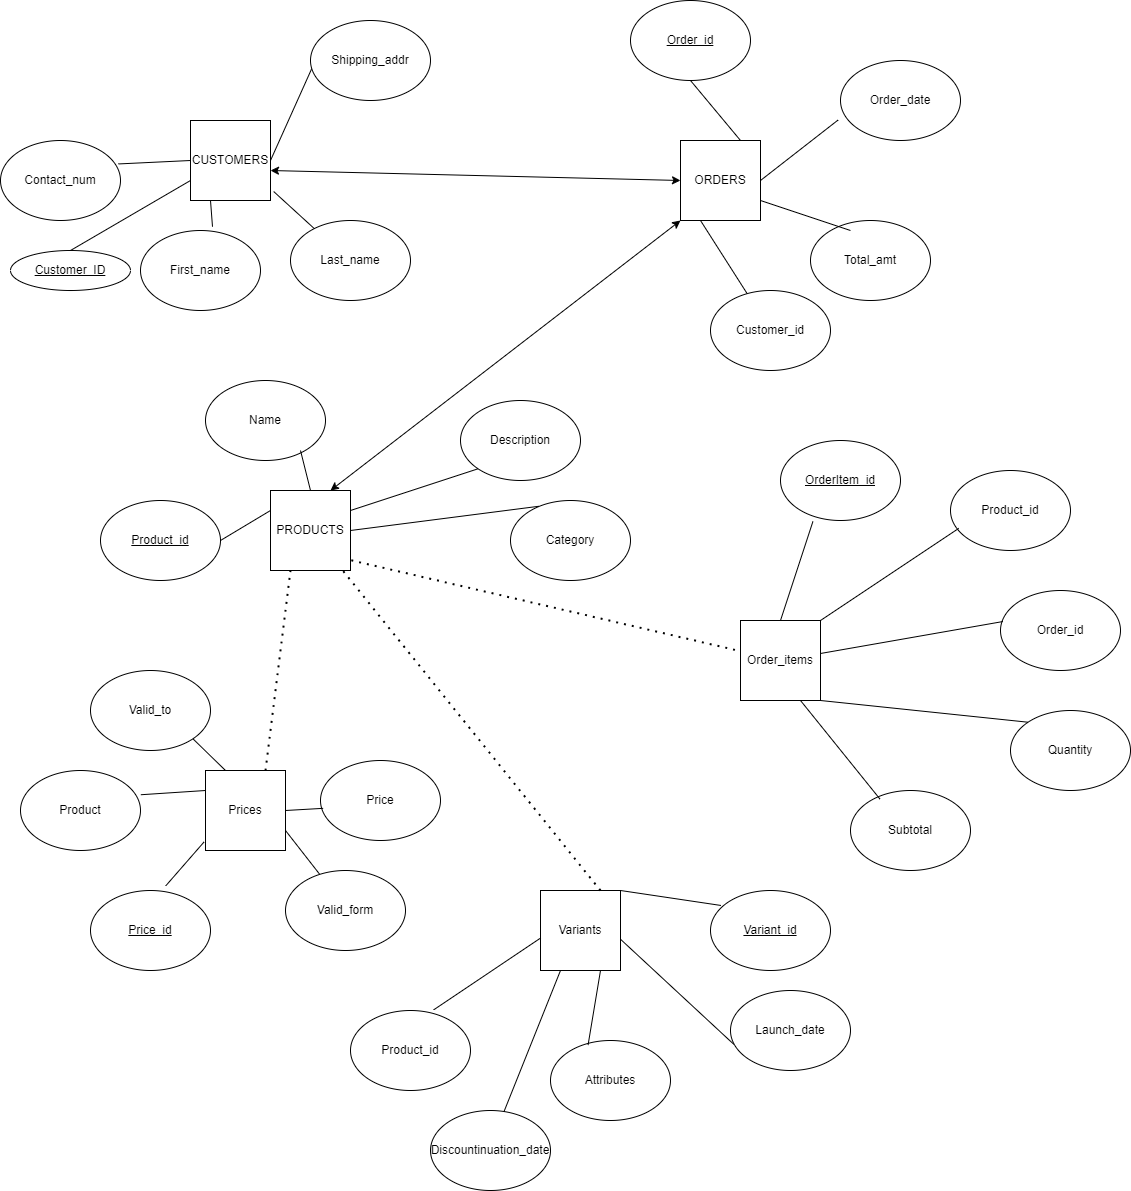

In [7]:
!pip install faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.3 MB/s eta 0:00:00


In [8]:
import random
import datetime
from faker import Faker

fake = Faker()

# Generate sample customer data
def generate_customers(num_customers):
    customers = []
    for _ in range(num_customers):
        customers.append({
            "customer_id": fake.unique.random_number(digits=5),
            "first_name": fake.first_name(),
            "last_name": fake.last_name(),
            "shipping_address": fake.address(),
            "contact_number": fake.phone_number(),

        })
    return customers

# Generate sample product data
def generate_products(num_products):
    products = []
    for _ in range(num_products):
        products.append({
            "product_id": fake.unique.random_number(digits=5),
            "name": fake.word(),
            "Description": fake.sentence(),
            "category": fake.random_element(["Electronics", "Clothing", "Books"])
        })
    return products

# Generate sample variant data for some products
def generate_variants(products):
    variants = []
    for product in products[:2]:
        for _ in range(2):
            variants.append({
                "variant_id": fake.unique.random_number(digits=5),
                "product_id": product["product_id"],
                "attributes": fake.sentence(),
                "launch_date": fake.date_between(start_date='-2y', end_date='today'),
                "discontinue_date": fake.date_between(start_date='today', end_date='+2y')
            })
    return variants

# Generate sample price data for products and variants
def generate_prices(products, variants):
    prices = []
    for product in products:
        prices.append({
            "product_id": product["product_id"],
            "price": round(random.uniform(50, 300), 2),
            "valid_from": datetime.date(2021, 1, 1),
            "valid_to": datetime.date(2022, 12, 31)
        })
    for variant in variants:
        prices.append({
            "product_id": variant["product_id"],
            "price": round(random.uniform(30, 150), 2),
            "valid_from": variant["launch_date"],
            "valid_to": variant["discontinue_date"]
        })
    return prices

# Generate sample order data with at least 2 years of history
def generate_orders(customers, products, num_orders):
    orders = []
    start_date = datetime.date(2020, 1, 1)
    for _ in range(num_orders):
        order_date = fake.date_between_dates(start_date, datetime.date(2022, 12, 31))
        orders.append({
            "order_id": fake.unique.random_number(digits=5),
            "customer_id": random.choice(customers)["customer_id"],
            "order_date": order_date,
            "total_amount": round(random.uniform(50, 500), 2)
        })
    return orders

# Generate sample data
num_customers = 10
num_products = 10
num_orders = 200

customers = generate_customers(num_customers)
products = generate_products(num_products)
variants = generate_variants(products)
prices = generate_prices(products, variants)
orders = generate_orders(customers, products, num_orders)

# You can now insert this data into a database using SQL queries or an ORM.


In [9]:
import sqlite3
import random
import datetime
from faker import Faker

fake = Faker()

# Create a SQLite database and connect
conn = sqlite3.connect('ecommerce.db')
cursor = conn.cursor()

# Create tables
cursor.execute('''
    CREATE TABLE Customers (
        CustomerID INTEGER PRIMARY KEY,
        FirstName TEXT,
        LastName TEXT,
        ShippingAddress TEXT,
        ContactNumber TEXT
    )
''')

cursor.execute('''
    CREATE TABLE Products (
        ProductID INTEGER PRIMARY KEY,
        Name TEXT,
        Category TEXT,
        DESCRIPTION TEXT
    )
''')

cursor.execute('''
    CREATE TABLE Variants (
        VariantID INTEGER PRIMARY KEY,
        ProductID INTEGER,
        Attributes TEXT,
        LaunchDate DATE,
        DiscontinueDate DATE,
        FOREIGN KEY (ProductID) REFERENCES Products(ProductID)
    )
''')

cursor.execute('''
    CREATE TABLE Prices (
        PriceID INTEGER PRIMARY KEY,
        ProductID INTEGER,
        VariantID INTEGER,
        Price REAL,
        ValidFrom DATE,
        ValidTo DATE,
        FOREIGN KEY (ProductID) REFERENCES Products(ProductID),
        FOREIGN KEY (VariantID) REFERENCES Variants(VariantID)
    )
''')

cursor.execute('''
    CREATE TABLE Orders (
        OrderID INTEGER PRIMARY KEY,
        CustomerID INTEGER,
        OrderDate DATE,
        TotalAmount REAL,
        FOREIGN KEY (CustomerID) REFERENCES Customers(CustomerID)
    )
''')

# Generate and insert sample data
num_customers = 10
num_products = 10
num_orders = 200

for _ in range(num_customers):
    cursor.execute('''
        INSERT INTO Customers (FirstName, LastName, ShippingAddress, ContactNumber)
        VALUES (?, ?, ?, ?)
    ''', (fake.first_name(), fake.last_name(), fake.address(), fake.phone_number()))

for _ in range(num_products):
    cursor.execute('''
        INSERT INTO Products (Name, Category)
        VALUES (?, ?)
    ''', (fake.word(), fake.random_element(["Electronics", "Clothing", "Books"])))

for product in range(2):  # Create variants for the first two products
    for _ in range(2):
        cursor.execute('''
            INSERT INTO Variants (ProductID, Attributes, LaunchDate, DiscontinueDate)
            VALUES (?, ?, ?, ?)
        ''', (product + 1, fake.sentence(), fake.date_this_year(), fake.date_this_year()))

for _ in range(num_products):
    cursor.execute('''
        INSERT INTO Prices (ProductID, Price, ValidFrom, ValidTo)
        VALUES (?, ?, ?, ?)
    ''', (random.randint(1, num_products), round(random.uniform(10, 300), 2), fake.date_this_year(), fake.date_this_year()))

for _ in range(num_orders):
    cursor.execute('''
        INSERT INTO Orders (CustomerID, OrderDate, TotalAmount)
        VALUES (?, ?, ?)
    ''', (random.randint(1, num_customers), fake.date_between(start_date='-2y', end_date='today'), round(random.uniform(50, 500), 2)))

# Commit changes and close the connection
conn.commit()
conn.close()


# Q2


#

In [18]:
import sqlite3

conn = sqlite3.connect('ecommerce.db')
cursor = conn.cursor()

query = '''
    SELECT
        c.CustomerID,
        c.FirstName,
        c.LastName,
        AVG(o.TotalAmount) AS AverageOrderAmount
    FROM
        Customers c
    JOIN
        Orders o ON c.CustomerID = o.CustomerID
    WHERE
        o.OrderDate >= date('now', '-6 months')
    GROUP BY
        c.CustomerID, c.FirstName, c.LastName
    ORDER BY
        AverageOrderAmount DESC
    LIMIT 5;
'''

result = cursor.execute(query).fetchall()
for row in result:
    print(row)

conn.close()


(6, 'Karen', 'Palmer', 433.02500000000003)
(9, 'Andrew', 'Hughes', 337.21555555555557)
(2, 'James', 'Dougherty', 334.7033333333334)
(7, 'Ruth', 'Ramirez', 315.02200000000005)
(4, 'Jeffrey', 'Smith', 313.26374999999996)


In [19]:
import sqlite3

conn = sqlite3.connect('ecommerce.db')
cursor = conn.cursor()

query = '''
    SELECT
        c.CustomerID,
        c.FirstName,
        c.LastName
    FROM
        Customers c
    JOIN
        Orders o ON c.CustomerID = o.CustomerID
    WHERE
        strftime('%Y', o.OrderDate) = strftime('%Y', 'now')
        AND o.TotalAmount < (
            SELECT SUM(TotalAmount)
            FROM Orders
            WHERE CustomerID = c.CustomerID
            AND strftime('%Y', OrderDate) = strftime('%Y', 'now', '-1 year')
        );
'''

result = cursor.execute(query).fetchall()
for row in result:
    print(row)

conn.close()


(3, 'Alyssa', 'Obrien')
(7, 'Ruth', 'Ramirez')
(6, 'Karen', 'Palmer')
(4, 'Jeffrey', 'Smith')
(9, 'Andrew', 'Hughes')
(9, 'Andrew', 'Hughes')
(8, 'Jeffrey', 'Ferguson')
(10, 'Steven', 'Foster')
(9, 'Andrew', 'Hughes')
(3, 'Alyssa', 'Obrien')
(9, 'Andrew', 'Hughes')
(9, 'Andrew', 'Hughes')
(3, 'Alyssa', 'Obrien')
(5, 'Emily', 'Kim')
(6, 'Karen', 'Palmer')
(2, 'James', 'Dougherty')
(3, 'Alyssa', 'Obrien')
(5, 'Emily', 'Kim')
(4, 'Jeffrey', 'Smith')
(10, 'Steven', 'Foster')
(10, 'Steven', 'Foster')
(1, 'Kimberly', 'Morse')
(9, 'Andrew', 'Hughes')
(3, 'Alyssa', 'Obrien')
(2, 'James', 'Dougherty')
(3, 'Alyssa', 'Obrien')
(6, 'Karen', 'Palmer')
(5, 'Emily', 'Kim')
(3, 'Alyssa', 'Obrien')
(6, 'Karen', 'Palmer')
(9, 'Andrew', 'Hughes')
(1, 'Kimberly', 'Morse')
(9, 'Andrew', 'Hughes')
(9, 'Andrew', 'Hughes')
(10, 'Steven', 'Foster')
(8, 'Jeffrey', 'Ferguson')
(9, 'Andrew', 'Hughes')
(3, 'Alyssa', 'Obrien')
(1, 'Kimberly', 'Morse')
(3, 'Alyssa', 'Obrien')
(8, 'Jeffrey', 'Ferguson')
(6, 'Karen', 

In [ ]:
import sqlite3

# Create a connection to the database
conn = sqlite3.connect('ecommerce.db')
cur = conn.cursor()

# Create the cumulative_purchases table
cur.execute('CREATE TABLE cumulative_purchases (customer_id INTEGER, product_category TEXT, cumulative_purchase INTEGER)')

# Insert data into the table
cur.execute('INSERT INTO cumulative_purchases (customer_id, product_category, cumulative_purchase) VALUES (1, "Electronics", 100)')
conn.commit()

# Query the data in the table
cur.execute('SELECT customer_id, product_category, cumulative_purchase FROM cumulative_purchases')
rows = cur.fetchall()

for row in rows:
  print(row)

# Close the connection to the database
conn.close()


In [ ]:
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('ecommerce.db')  # Replace with your database path
cursor = conn.cursor()

# Retrieve the list of top 5 selling products with sales bifurcated by variants
query = '''
WITH ProductSales AS (
    SELECT
        p.ProductID,
        p.Name,
        v.VariantID,
        v.Attributes,
        SUM(o.TotalAmount) AS TotalSales
    FROM
        Products p
    LEFT JOIN
        Variants v ON p.ProductID = v.ProductID
    LEFT JOIN
        Prices pr ON p.ProductID = pr.ProductID
    LEFT JOIN
        Orders o ON pr.VariantID = o.VariantID
    GROUP BY
        p.ProductID, p.Name, v.VariantID, v.Attributes
)
SELECT
    p.ProductID,
    p.Name,
    v.VariantID,
    v.Attributes,
    TotalSales
FROM
    ProductSales
ORDER BY
    TotalSales DESC
LIMIT 5;
'''

cursor.execute(query)
result = cursor.fetchall()

# Print the results
for row in result:
    print(row)

# Close the connection
conn.close()

In [ ]:
!pip install sqlite3


# Q3


[link text](https://file.notion.so/f/s/98b0fa4b-2a85-40e0-af20-5a2785c55c92/Untitled.json?id=b6059ad3-5ee5-4f32-84b6-b03e68bdca98&table=block&spaceId=ca71608c-1cc3-4167-857a-24da97c78717&expirationTimestamp=1692806400000&signature=aCNC0j4fZSzMJlVfeQjrLLu_4pSNY-Ur5sOKggz9BhI&downloadName=nested_data.json)


In [21]:
!pip install wget


  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=62e677a0fc3497148609b22d46089378243af569de9e23c43905127c9036f44f
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [28]:
import wget

# The link to the file you want to download
link = 'https://file.notion.so/f/s/98b0fa4b-2a85-40e0-af20-5a2785c55c92/Untitled.json?id=b6059ad3-5ee5-4f32-84b6-b03e68bdca98&table=block&spaceId=ca71608c-1cc3-4167-857a-24da97c78717&expirationTimestamp=1692806400000&signature=aCNC0j4fZSzMJlVfeQjrLLu_4pSNY-Ur5sOKggz9BhI&downloadName=nested_data.json'

# Download the file
wget.download(link)

'Untitled.json'

In [ ]:
import pandas as pd
import json

# Load the JSON data
json_url = 'https://file.notion.so/f/s/98b0fa4b-2a85-40e0-af20-5a2785c55c92/Untitled.json?id=b6059ad3-5ee5-4f32-84b6-b03e68bdca98&table=block&spaceId=ca71608c-1cc3-4167-857a-24da97c78717&expirationTimestamp=1692806400000&signature=aCNC0j4fZSzMJlVfeQjrLLu_4pSNY-Ur5sOKggz9BhI&downloadName=nested_data.json'
response = pd.read_json(json_url)




# Flatten the nested JSON data
flattened_data = pd.json_normalize(response['data'])
flattened_data = pd.json_normalize(response['data'])

# Extract required columns for each entity
concerts = flattened_data[['id', 'date', 'time', 'venue']]
works = flattened_data['program'].explode().reset_index()
works.rename(columns={'program': 'work'}, inplace=True)
artists = flattened_data['soloists'].explode().reset_index()
artists.rename(columns={'soloists': 'artist'}, inplace=True)

# Create a relational database-like schema
orchestra_df = pd.DataFrame(response['orchestra'])
orchestra_id = orchestra_df['id'][0]
orchestra_name = orchestra_df['name'][0]
orchestra_data = pd.DataFrame({'id': [orchestra_id], 'name': [orchestra_name]})

# Store the data into normalized tables
tables = {
    'Concerts': concerts,
    'Works': works,
    'Artists': artists,
    'Orchestra': orchestra_data
}

# Insert data into SQLite database
import sqlite3

conn = sqlite3.connect('normalized_data.db')
for table_name, table_data in tables.items():
    table_data.to_sql(table_name, conn, index=False, if_exists='replace')

# Close the connection
conn.close()

In [ ]:
import pandas as pd
import json

# Load JSON data
with open('nested_data.json') as f:
    data = json.load(f)

# Extract data
artists_data = []
works_data = []
concerts_data = []
orchestras_data = []

for concert in data['concerts']:
    concerts_data.append({
        'id': concert['id'],
        'date': concert['date'],
        'location': concert['location']
    })

    for artist in concert['artists']:
        artists_data.append({
            'id': artist['id'],
            'name': artist['name']
        })

    for work in concert['works']:
        works_data.append({
            'id': work['id'],
            'title': work['title']
        })

for orchestra in data['orchestras']:
    orchestras_data.append({
        'id': orchestra['id'],
        'name': orchestra['name']
    })

# Create dataframes
artists_df = pd.DataFrame(artists_data)
works_df = pd.DataFrame(works_data)
concerts_df = pd.DataFrame(concerts_data)
orchestras_df = pd.DataFrame(orchestras_data)

# Save data to CSV files or store in a database
artists_df.to_csv('artists.csv', index=False)
works_df.to_csv('works.csv', index=False)
concerts_df.to_csv('concerts.csv', index=False)
orchestras_df.to_csv('orchestras.csv', index=False)


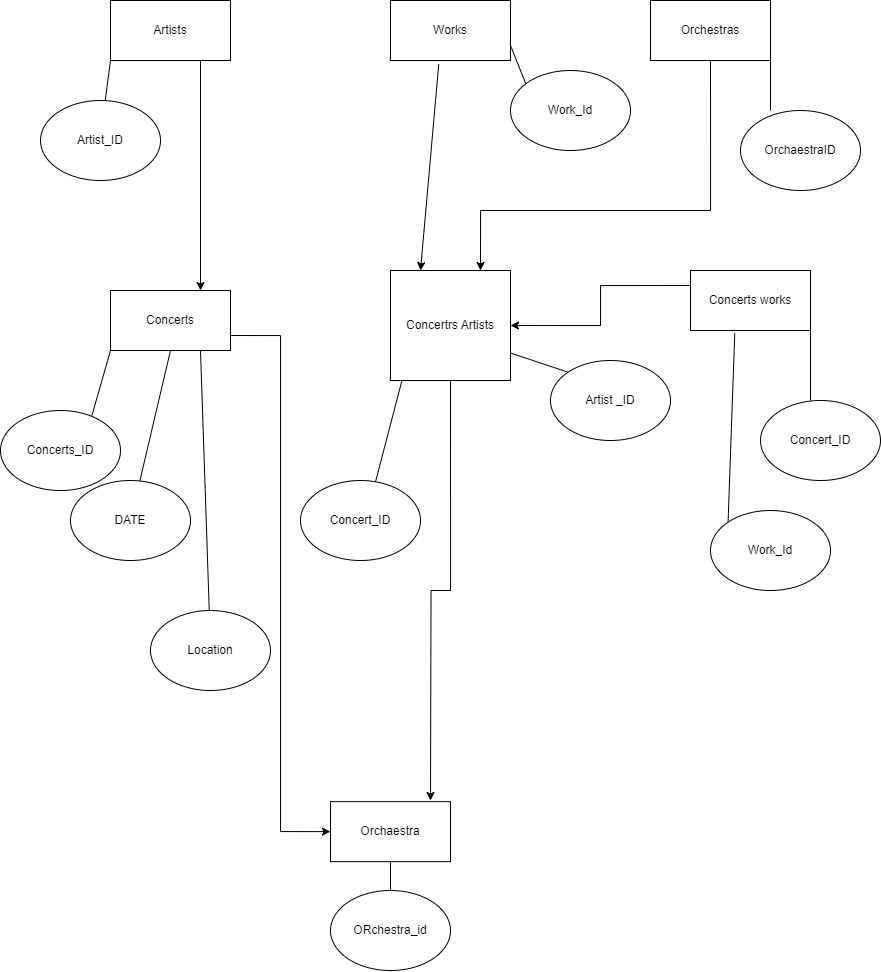

# Q4


In [ ]:
spark.conf.set("spark.databricks.delta.schema.autoMerge.enabled", "true")

cloud_storage_location = "https://s3.console.aws.amazon.com/s3/buckets/streamingjson?region=eu-north-1"
schema = ["name", "popcornscore", "rating","tomatoscore", "IMDB Metascore","Gross","Genre"]

In [ ]:
json_stream = spark.readStream \ #ingest json file
    .schema(schema) \
    .format("json") \
    .load("https://dbc-cdd98f35-bd6d.cloud.databricks.com/explore/data/main?o=743501856207247")

In [ ]:
query = json_stream.writeStream \
    .format("delta") \
    .outputMode("append") \
    .option("checkpointLocation", "https://dbc-cdd98f35-bd6d.cloud.databricks.com/explore/data/main?o=743501856207247") \
    .start("/my_delta_table/")


In [ ]:
autoloader_job = autoloader.create_job(
    cloud_storage_location=cloud_storage_location,
    schema=schema,
    output_table="my_delta_table"
)

autoloader_job.run()

# Q5


In [1]:
import pandas as pd

# Load the Excel data
excel_file = "Time Series.xlsx"
df = pd.read_excel(excel_file)

# Sort the data by bot ID and timestamp
df.sort_values(by=['Name', 'Start'], inplace=True)

# Initialize variables
bot_periods = []
current_period = None

# Iterate through the data to identify continuous periods
for index, row in df.iterrows():
    name = row['Name']
    activity = row['Activity']
    timestamp1 = row['Start']
    timestamp2 = row['End']

    if current_period is None or current_period['name'] != name:
        current_period = {'name': name, 'start_time': timestamp1, 'end_time': timestamp2, 'activities': [activity]}
        bot_periods.append(current_period)
    else:
        if (timestamp1 - current_period['end_time']).seconds <= 300:  # Assuming a 5-minute gap indicates continuous work
            current_period['end_time'] = timestamp2
            current_period['activities'].append(activity)
        else:
            current_period = {'name': name, 'start_time': timestamp1, 'end_time': timestamp2, 'activities': [activity]}
            bot_periods.append(current_period)

# Print the results
for period in bot_periods:
    print(f"Name: {period['name']}")
    print(f"Work Period: {period['start_time']} - {period['end_time']}")
    print(f"Activities: {', '.join(period['activities'])}")
    print("-----------------------")


Streaming output truncated to the last 5000 lines.
Name: Sharan
Work Period: 2023-06-18 01:07:52.620000 - 2023-08-28 05:55:52.620000
Activities: Reporting
-----------------------
Name: Sharan
Work Period: 2023-06-18 01:07:52.620000 - 2023-09-20 15:31:52.620000
Activities: Remote Inspection
-----------------------
Name: Sharan
Work Period: 2023-06-18 01:07:52.620000 - 2023-09-04 01:07:52.620000
Activities: Send Email
-----------------------
Name: Sharan
Work Period: 2023-06-18 03:31:52.620000 - 2023-10-14 10:43:52.620000
Activities: Reply to Customers
-----------------------
Name: Sharan
Work Period: 2023-06-18 05:55:52.620000 - 2023-08-08 15:31:52.620000
Activities: Reply to Customers
-----------------------
Name: Sharan
Work Period: 2023-06-18 08:19:52.620000 - 2023-08-27 01:07:52.620000
Activities: Fund raising
-----------------------
Name: Sharan
Work Period: 2023-06-18 10:43:52.620000 - 2023-04-10 01:07:52.620000
Activities: Reporting
-----------------------
Name: Sharan
Work Perio

In [1]:
!pip install pandas openpyxl


In [3]:
import pandas as pd

# Load the Excel file
excel_file = 'Time Series.xlsx'
df = pd.read_excel(excel_file)

# Convert the 'Start' and 'End' columns to datetime
df['Start'] = pd.to_datetime(df['Start'])
df['End'] = pd.to_datetime(df['End'])

# Sort the DataFrame by 'Name' and 'Start'
df.sort_values(by=['Name', 'Start'], inplace=True)

# Calculate the time difference between consecutive rows
df['TimeDiff'] = df.groupby('Name')['Start'].diff()

# Define a threshold for detecting idle time
idle_threshold = pd.Timedelta(minutes=15)

# Identify continuous periods of work
df['WorkPeriod'] = (df['TimeDiff'] > idle_threshold).cumsum()

# Group by 'Name' and 'WorkPeriod', and aggregate activities as an array
result = df.groupby(['Name', 'WorkPeriod'])['Activity'].agg(list).reset_index()

# Rename columns for clarity
result.rename(columns={'WorkPeriod': 'Period', 'Activity': 'Activities'}, inplace=True)

# Convert the 'Period' column to a human-readable format
result['Period'] = result.groupby('Name')['Period'].transform(lambda x: x + 1)

print(result)


        Name  Period                                  Activities
0     Deepti       1  [Business Development, Reply to Customers]
1     Deepti       2                  [Send Email, Fund raising]
2     Deepti       3          [Send Email, Business Development]
3     Deepti       4                        [Reply to Customers]
4     Deepti       5                                 [Reporting]
...      ...     ...                                         ...
6613  Sharan    6610                        [Reporting, Podcast]
6614  Sharan    6611                          [Updates, Updates]
6615  Sharan    6612      [Call, Send Email, Reply to Customers]
6616  Sharan    6613          [Fund raising, Reporting, Podcast]
6617  Sharan    6614                              [Fund raising]

[6618 rows x 3 columns]
